# Final Model Configuration

In this notebook, it is covered the conformation of the final regression model to predict cars prices. To this aim, the next steps will be followed:
* Divide the dataset into train & split values.
* Train a Random Forest Regressor with the optimal hyperparameters found.
* Predict on test data.
* Plot actual vs predicted values.
* Model persistence. Saving the model with pickle.

In [1]:
import pandas as pd
import numpy as np
from time import time
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from modules.model_evaluator import run_cv_reg

## 1. Import data

In [2]:
root = r'../data/regression/cars_reg_trf.csv'

df = pd.read_csv(root)

df.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,gearbox_Automatic,gearbox_Direct,...,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded,price
0,-1.120443,0.285121,-2.877530,-2.143610,-0.679227,-2.897385,-2.456544,1.199172,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153,5500
1,1.303557,-1.624785,-0.685567,1.345832,1.358362,-0.272066,-0.085500,-1.377568,-5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.521013,10900
2,-0.572277,-1.297705,0.171631,0.937119,-0.833062,0.438088,-1.220053,-0.794587,5.199338,-5.199338,...,-5.199338,5.199338,-5.199338,0.698331,0.833062,0.596109,5.199338,5.199338,1.521013,36100
3,0.635580,0.540027,0.519795,0.651025,0.361889,1.079060,0.933230,-1.018128,5.199338,-5.199338,...,-5.199338,-5.199338,5.199338,0.698331,1.663600,-1.056848,-0.902609,5.199338,1.521013,28000
4,3.744070,-2.967122,0.012559,-0.174181,3.436439,0.439471,1.120443,-2.877530,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.367258,5.199338,1.521013,27990


## 2. Dividing the dataset

In [17]:
X = df.drop('price', axis=1)
y = df['price']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(44292, 29) (11074, 29) (44292,) (11074,)


## 3. Train RF with the optimal hyperparameters

The hyperparameters for the `RF` have been chosen based on the results of the Grid Search cross-validation process:
- `bootstrap`: False
- `max_depth`: None
- `max_features`: 'sqrt'
- `min_samples_leaf`: 1
- `min_samples_split`: 10
- `n_estimators`: 250

In [5]:
start_time = time()

rf = RandomForestRegressor(bootstrap=False,
                           max_features='sqrt',
                           min_samples_split=10,
                           n_estimators=250
                          )

rf.fit(X_train, y_train)

exec_time = time() - start_time
print('The RF model was trained in: {:.2f} sec'.format(exec_time))

The RF model was trained in: 43.42 sec


## 4. Predict on test data

In [6]:
y_hat = rf.predict(X_test)

display(y_hat)
print("Min value predicted: {:.2f}\n\
Max value predicted: {:.2f}"\
      .format(np.min(y_hat), np.max(y_hat)))
print("y_hat shape: {}".format(y_hat.shape))

array([35786.57442381, 12588.06877778, 16514.89866667, ...,
       12050.04311111, 44650.48628095, 12543.18593651])

Min value predicted: 1125.31
Max value predicted: 89542.78
y_hat shape: (11074,)


## 5. Plot actual vs predicted values

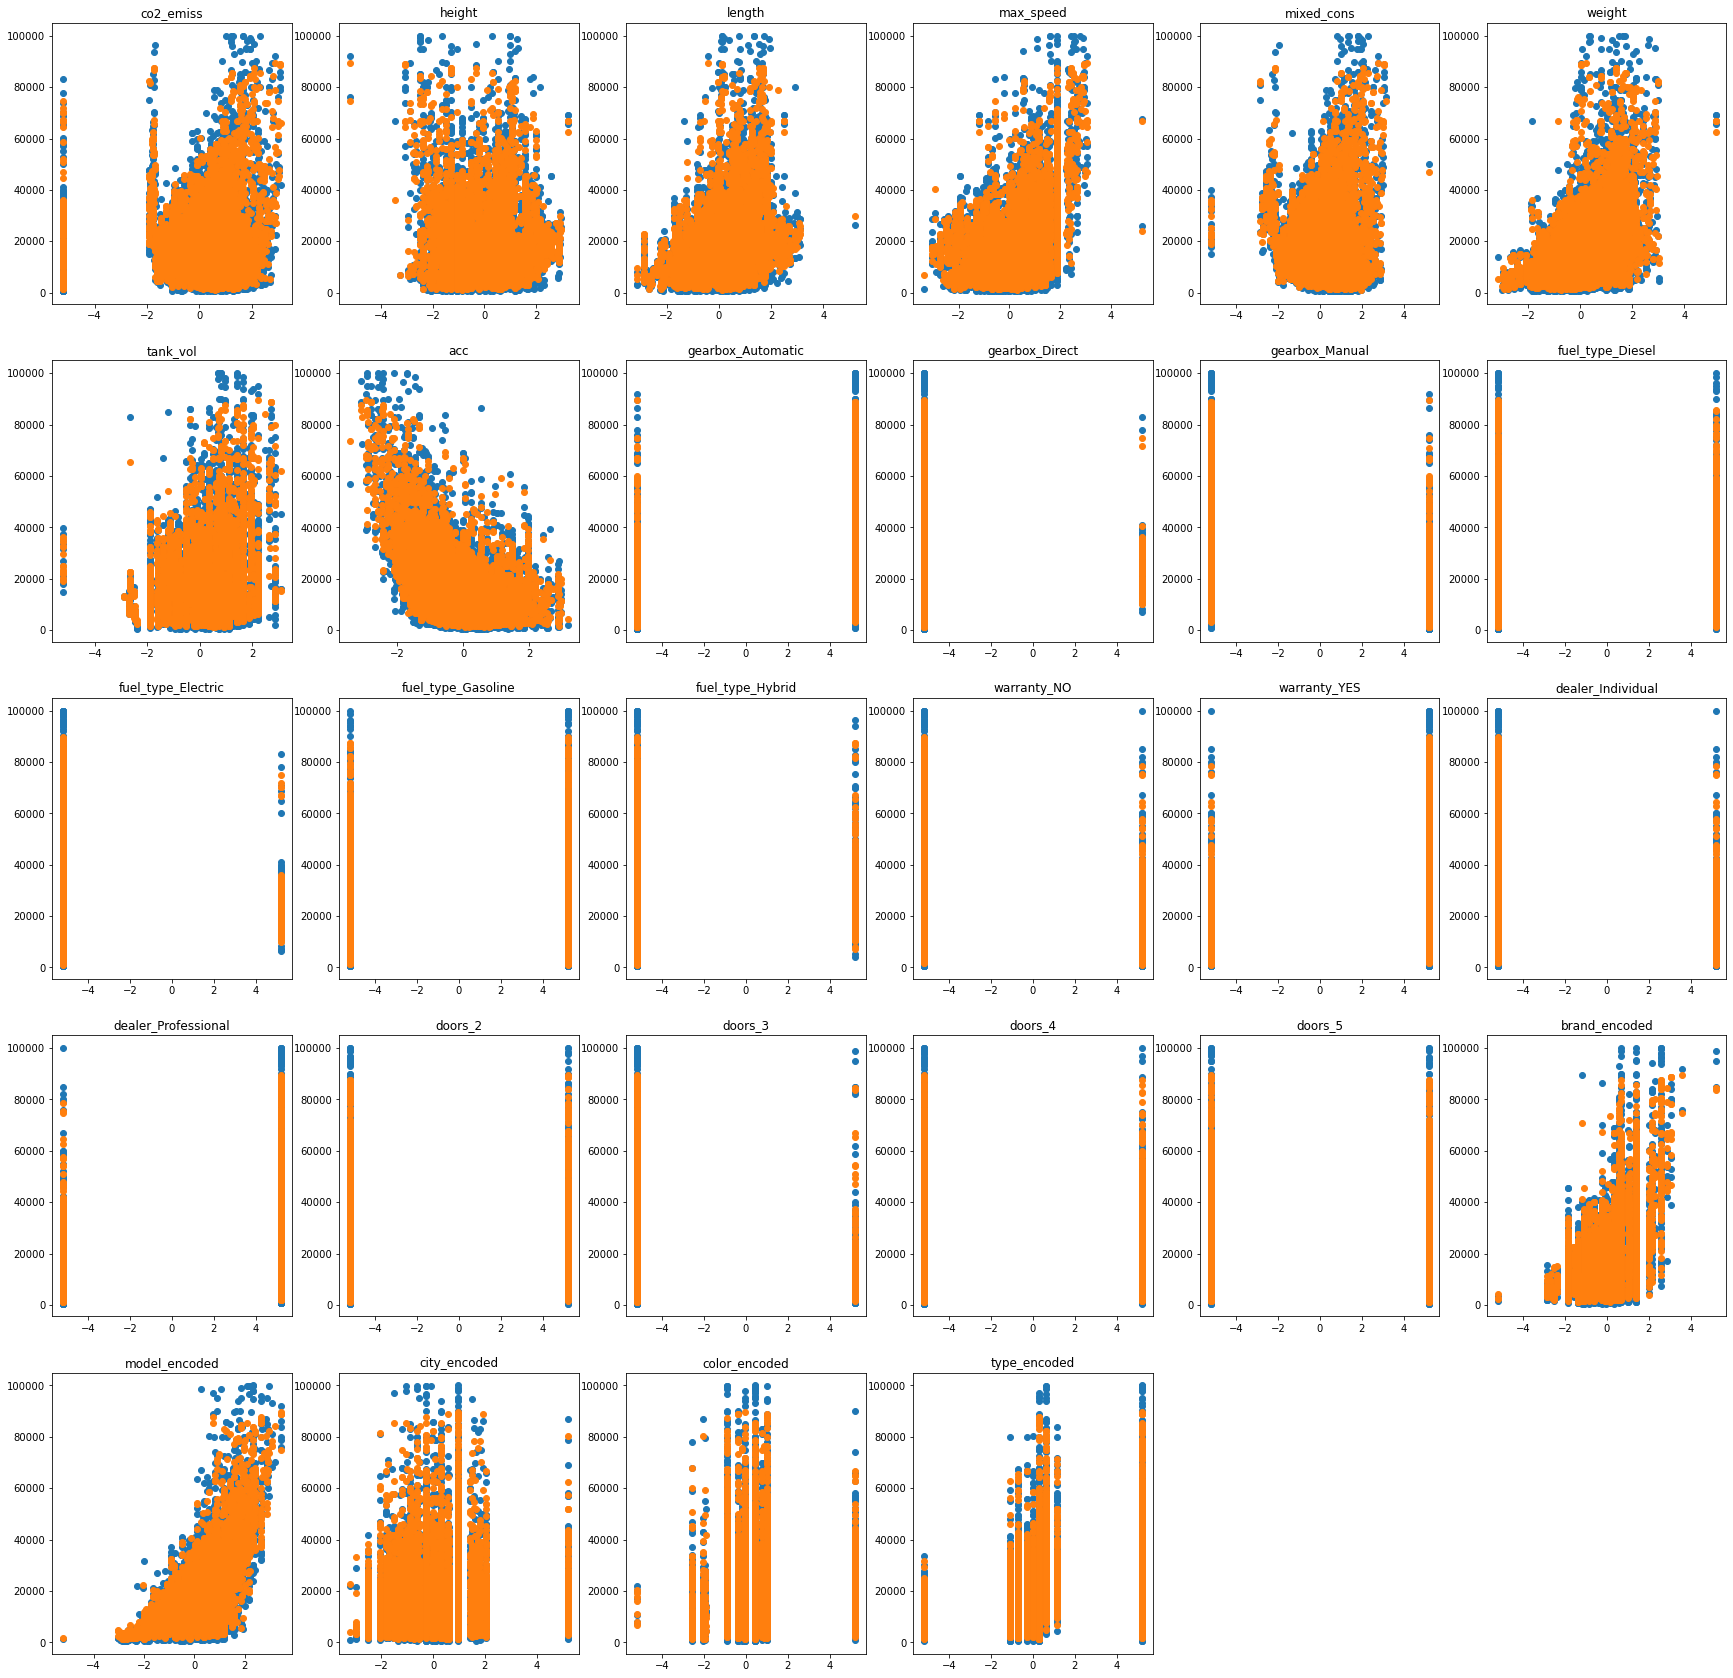

In [36]:
fig = plt.figure(figsize=(30,30))

columns = X_test.columns

for c, num in zip(columns, range(0,28)):
    ax = fig.add_subplot(5, 6, num+1)
    ax.scatter(X_test[c], y_test)
    ax.scatter(X_test[c], y_hat)
    ax.set_title(c)

plt
plt.show()

## 6. Model persistence